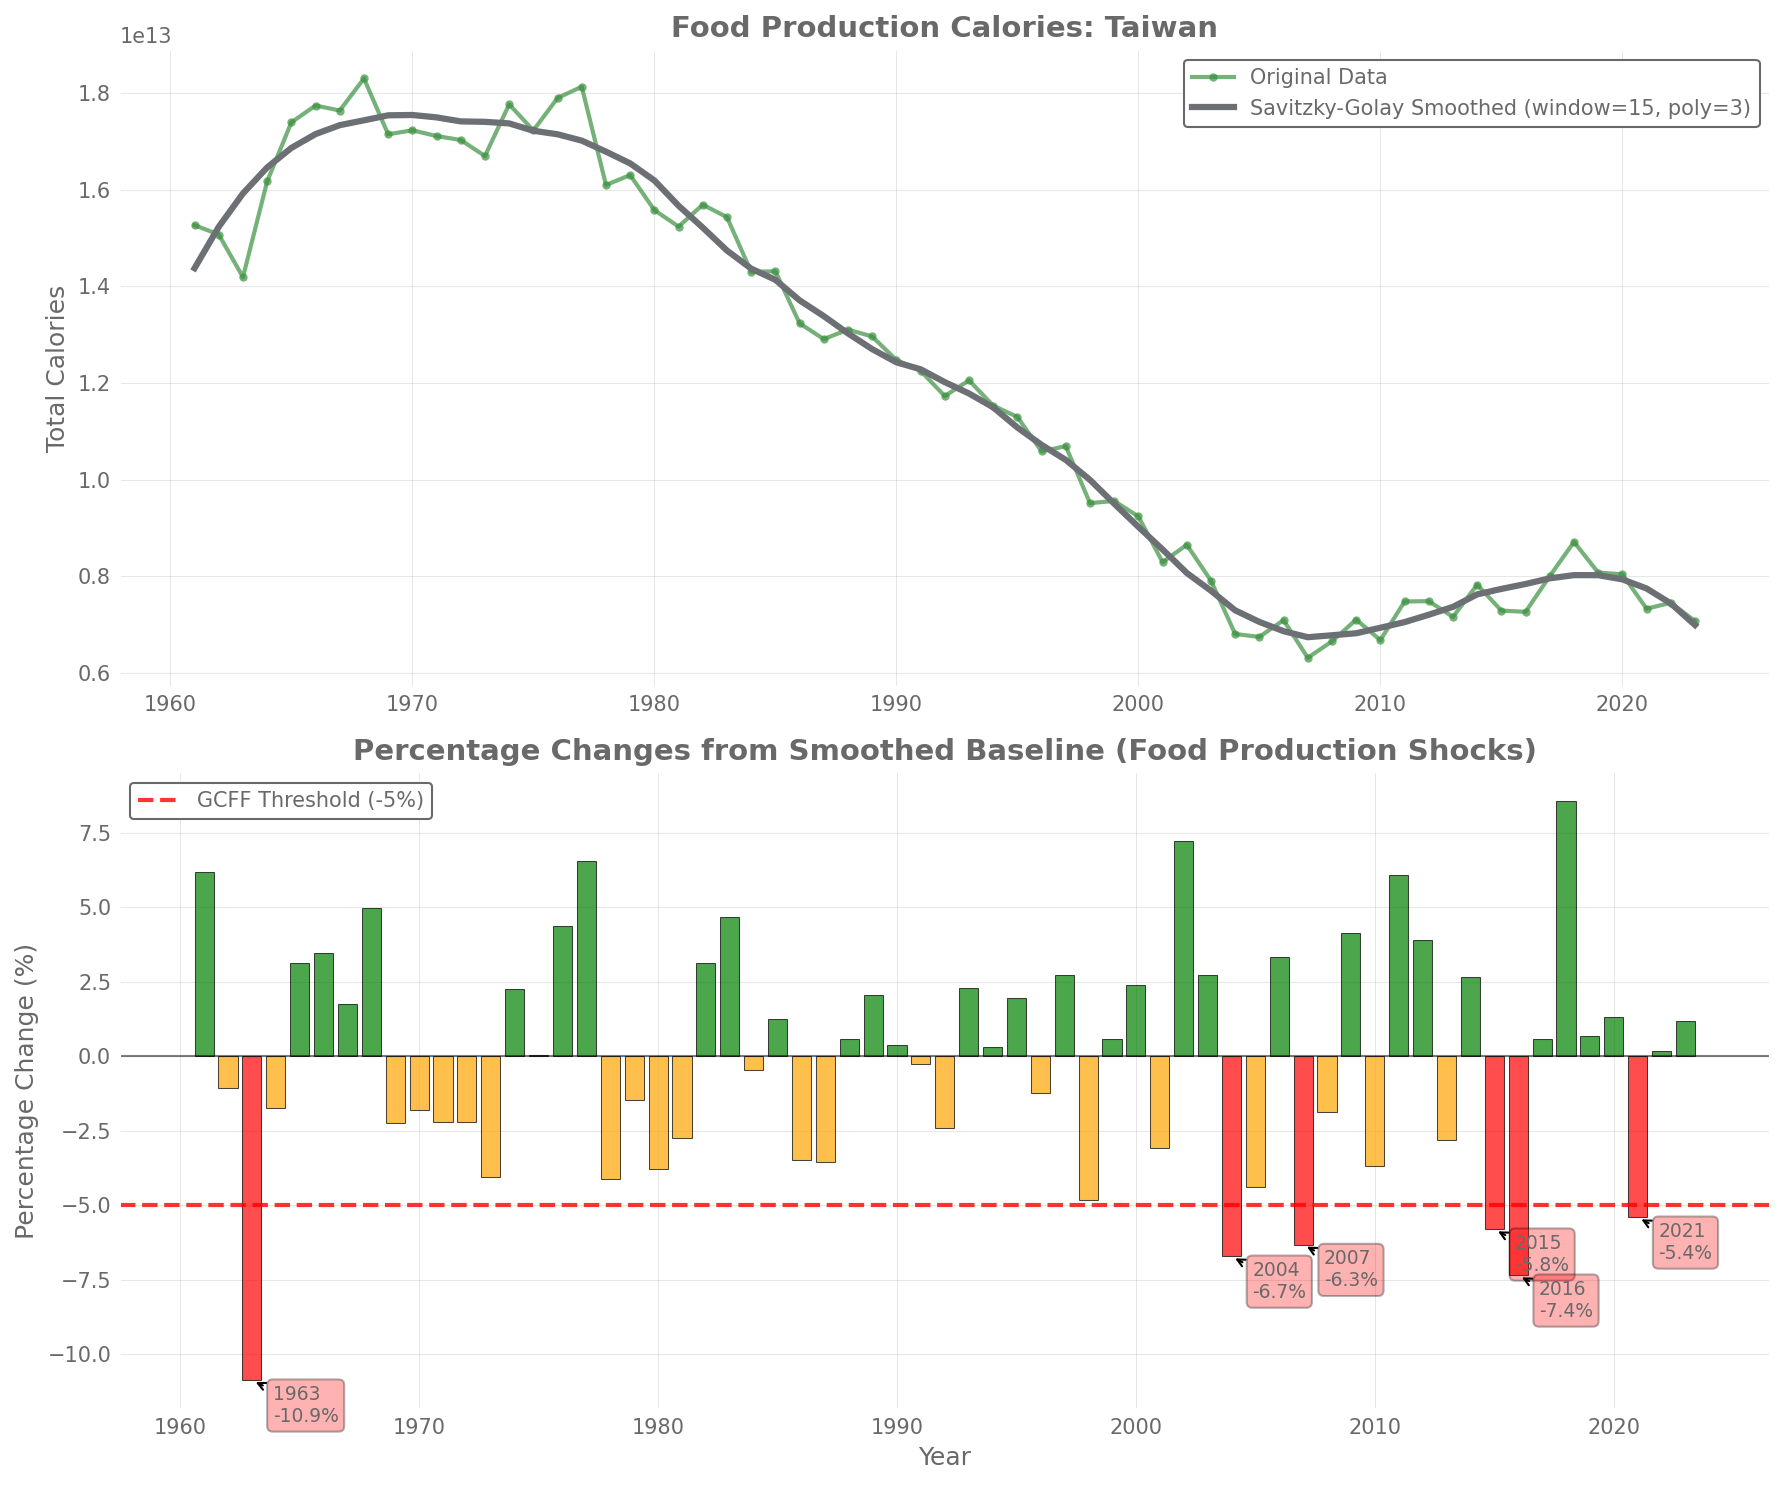


Summary for Taiwan:
Data range: 1961 - 2023
Number of years with data: 63
Savitzky-Golay parameters: window_length=15, polyorder=3

Shock Analysis:
Years with shocks ≤ -5%: 6
Years with shocks ≤ -10%: 1
Largest negative shock: -10.88% in 1963
Largest positive deviation: 8.57% in 2018

Years with GCFF-level shocks (≤ -5%):
  1963: -10.88%
  2004: -6.72%
  2007: -6.33%
  2015: -5.81%
  2016: -7.36%
  2021: -5.41%


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from scipy.signal import savgol_filter

# Add src directory to path to import our functions
sys.path.append('../src')
from calculate_food_shocks import calculate_changes_savgol

# Set ALLFED plotting style
plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")

# Load the calories data
calories_df = pd.read_csv('../results/calories.csv', index_col=0)

# Select country to visualize (change this to explore different countries)
selected_country = "Taiwan"  # Options: any country from calories_df.index
window_length = 15  # Must be odd number
polyorder = 3      # Must be less than window_length

# Extract data for selected country
country_data = calories_df.loc[selected_country]
years = [int(col) for col in country_data.index]
values = country_data.values

# Remove NaN values for processing
valid_mask = ~np.isnan(values)
years_clean = np.array(years)[valid_mask]
values_clean = values[valid_mask]

# Apply Savitzky-Golay filter to create smoothed baseline
smoothed_values = savgol_filter(values_clean, window_length, polyorder)

# Calculate percentage changes
pct_changes = ((values_clean - smoothed_values) / smoothed_values) * 100

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: Original data vs smoothed baseline
ax1.plot(years_clean, values_clean, 'o-', alpha=0.7, linewidth=2, 
        label='Original Data', markersize=4)
ax1.plot(years_clean, smoothed_values, '-', linewidth=3, 
        label=f'Savitzky-Golay Smoothed (window={window_length}, poly={polyorder})')
ax1.set_title(f'Food Production Calories: {selected_country}', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Calories', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Format y-axis to show values in scientific notation
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Bottom plot: Percentage changes (shocks)
colors = ['red' if x < -5 else 'orange' if x < 0 else 'green' for x in pct_changes]
bars = ax2.bar(years_clean, pct_changes, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)

# Add horizontal lines for shock thresholds
ax2.axhline(y=-5, color='red', linestyle='--', alpha=0.8, linewidth=2, label='GCFF Threshold (-5%)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

ax2.set_title('Percentage Changes from Smoothed Baseline (Food Production Shocks)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Percentage Change (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Highlight significant negative shocks
significant_shocks = pct_changes < -5
if np.any(significant_shocks):
   shock_years = years_clean[significant_shocks]
   shock_values = pct_changes[significant_shocks]
   for year, value in zip(shock_years, shock_values):
       ax2.annotate(f'{year}\n{value:.1f}%', 
                   xy=(year, value), xytext=(10, -20),
                   textcoords='offset points', fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary for {selected_country}:")
print(f"Data range: {years_clean[0]} - {years_clean[-1]}")
print(f"Number of years with data: {len(years_clean)}")
print(f"Savitzky-Golay parameters: window_length={window_length}, polyorder={polyorder}")
print(f"\nShock Analysis:")
print(f"Years with shocks ≤ -5%: {np.sum(pct_changes <= -5)}")
print(f"Years with shocks ≤ -10%: {np.sum(pct_changes <= -10)}")
print(f"Largest negative shock: {np.min(pct_changes):.2f}% in {years_clean[np.argmin(pct_changes)]}")
print(f"Largest positive deviation: {np.max(pct_changes):.2f}% in {years_clean[np.argmax(pct_changes)]}")

# Show the most significant shock years
if np.any(significant_shocks):
   print(f"\nYears with GCFF-level shocks (≤ -5%):")
   shock_years = years_clean[significant_shocks]
   shock_values = pct_changes[significant_shocks]
   for year, value in zip(shock_years, shock_values):
       print(f"  {year}: {value:.2f}%")
else:
   print(f"\nNo GCFF-level shocks (≤ -5%) detected for {selected_country}")